In [1]:
####################################################################################################
# Data Science Challenge
# 
# CHALLENGE DESCRIPTION:
#
# The goal is to predict the *default probability*. 
# The "default" variable in the training dataset indicates whether the client defaulted or not. 
# We are going to calculate the log loss based on the true value of the clients in the test dataset
# and on your probabilities.
#
# Author: Jean Phelippe Ramos de Oliveira - jean.phelippe92@gmail.com
# 
# DESCRIPTION:
#   Two supevised learning models were developed for this case:
#   * XGBoost Trees Model (https://xgboost.readthedocs.io/en/latest/)
#   * Random Forest Model (http://scikit-learn.org/stable/modules/ensemble.html#forest)
#
#    The first model is more robust but required more complex parameter tunning. 
#    The second is still an ensemble model but simpler to implement.
#    Both models were validated using Cross-Validation (logloss metrics)
#
# RESULTS (During Trainning):
#  * XGBoost Trees   LogLoss: ~0.301
#  * RandomForest    LogLoss: ~0.347
# 
# 
# OUTPUT: 
#   * .csv file containing probabilities for the Test dataset according to the instructions.
#   * Output using only XGBoot model. Similar approach can be used to output RF predictons.
#
####################################################################################################


import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline  

rcParams['figure.figsize'] = 12, 4

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import sklearn.model_selection as ms

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


from sklearn.ensemble import RandomForestClassifier

#Pandas Display settings
pd.set_option("display.max_rows",50,"display.max_columns", 50) 

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [81]:
#Importing datasets
train_original = pd.read_csv("./puzzle_train_dataset.csv")
test = pd.read_csv("./puzzle_test_dataset.csv")

In [3]:
#Visualize dataset (NaNs and unique values)
train = train_original.dropna(subset=['default']) # drop default = NA (no label)
unique = {}
uniqueValues = {}
for col in train[train.columns.difference(['ids'])]:
    uniqueValues[col] = train.groupby(col)['ids'].nunique()
    unique[col] = train[col].nunique()

stats = pd.DataFrame(unique.items(), columns=['column_name', 'unique_values'])
stats ['Sum(NaNs)'] = train.isnull().sum().reindex(stats['column_name']).reset_index(drop=True)
stats

,column_name,unique_values,Sum(NaNs)
0,score_1,7,0
1,score_2,35,0
2,score_3,87,0
3,score_4,59966,0
4,score_5,59966,0
5,score_6,59966,0
6,sign,12,18938
7,last_payment,108,77
8,zip,830,0
9,state,50,0


In [4]:
#Sanity Check
# Checking if gender, facebook_profile keys are ok 
# (gender should be m/f, facebook_profile should be True/False etc..)
# Also checking if the hashed values are matching in both Train and Test dataset.

print("Sanity Check:\n")
print(pd.DataFrame(uniqueValues['score_1']))
print("\n")
print(pd.DataFrame(uniqueValues['score_2']))
print("\n")
print(pd.DataFrame(uniqueValues['sign']))
print("\n")
print(pd.DataFrame(uniqueValues['facebook_profile']))
print("\n")
print(pd.DataFrame(uniqueValues['real_state']))
print("\n")
print(pd.DataFrame(uniqueValues['gender']))

# Check if for score_1, score_2, channel, state and real_state values in both test and train datasets match.
equalKeys = []
for col in ['score_1','score_2','channel','state','real_state']:
    keysTrain = train.groupby(col)['ids'].nunique()
    keysTest = test.groupby(col)['ids'].nunique()
    isEqual = pd.Series(keysTrain.keys()).equals(pd.Series(keysTest.keys()))
    equalKeys.append(isEqual)

print(equalKeys) # 'state' doesn't match 

# because test dataset doesn't have all possible values for 'state', however 47 values match
print(pd.Series(test.groupby('state')['ids'].nunique().keys()).isin(pd.Series(train.groupby('state')['ids'].nunique().keys())))

Sanity Check:

                            ids
score_1                        
1Rk8w4Ucd5yR3KcqZzLdow==  14853
4DLlLW62jReXaqbPaHp1vQ==  10595
8k8UDR4Yx0qasAjkGrUZLw==   8496
DGCQep2AE5QRkNCshIAlFQ==  20484
e4NYDor1NOw6XKGE60AWFw==   3662
fyrlulOiZ+5hoFqLa6UbDQ==    341
smzX0nxh5QlePvtVf6EAeg==   1535


                           ids
score_2                       
+2hzpeP1RWr8PEvL1WTUdw==    88
+CxEO4w7jv3QPI/BQbyqAA==  1517
/tdlnWjXoZ3OjdtBXzdOJQ==  3603
5/uMrqKj3OL/Xk5OrGx9fg==    17
55UK234RR1d7HIWJjmq9tw==    63
6J1ZMTzN5GKHXnhM4J1JbA==   159
7h+tk4z7O9brtBSe1rNjxA==  3274
7h8PTkrlTWUPP3yuyP4rUg==  1844
A+QuW1n/ABeiVVe/9CRZ9Q==   546
Fv28Bz0YRTVAT5kl1bAV6g==  3315
IOVu8au3ISbo6+zmfnYwMg==  2899
LCak332j+TYFqHC3NDwiqg==  2644
NLvAOzzmJba/0zolQnWF5Q==   837
O4i7FxcROACMVTCgI0WXuA==   223
OlDYtdljgSSYM/M1L2CRaQ==  1908
RO7MTL+j4PH2gNzbhNTq/A==  4217
SaamrHMo23l/3TwXOWgVzw==  4620
YLGMUI9hObSh6wD/xfanGg==  1622
bopP0NxW3+r8tn9xIHTaOw==   467
cdpgyOyZS04uXerMNu7uCw==   657
d/7Hedyz7ovK9

In [78]:
### Cleaning train dataset for XGBoost
# XGBoost accept dataset with missing values (missing values can be handled in the algorithm)
print("Cleaning train dataset. This may take a while...")
xtrain = train_original.dropna(subset=['default']) # drop default = NA (no label)

## Train dataset
xtrain = xtrain.drop('channel', axis=1)  # channel has just 1 value (No added information)

xtrain = xtrain.drop('reason', axis=1)   # reason is too sparce(~20K unique Values)

xtrain = xtrain.drop('job_name', axis=1) # job_name has too many categories (~42K)

xtrain = xtrain.drop('ok_since', axis=1) # ok_since has too many NAs (~35K)

xtrain = xtrain.drop('sign', axis=1)     #sign doesn't seems relevant

xtrain = xtrain.drop('zip', axis=1)      #Too many cateogires (830)

xtrain = xtrain.drop('state', axis=1)    # Removed due to mismatch with test dataset

#Convert last_payment and end_last_loan to number of days between last_payment and end_last_loan
# A negative number means the last payment was made after the end of the last loan

xtrain['last_payment'] = pd.to_datetime(xtrain['last_payment'], infer_datetime_format=True)
xtrain['end_last_loan'] = pd.to_datetime(xtrain['end_last_loan'], infer_datetime_format=True)

def days_from_last_payment(row):
    if pd.isnull(row).any():
        return np.nan
    else:
        delta = row['end_last_loan'] - row['last_payment']
        return (delta / np.timedelta64(1, 'D'))
    
xtrain['n_days_btwn_payment_loan'] = xtrain[['last_payment','end_last_loan']].apply(days_from_last_payment, axis=1)

xtrain = xtrain.drop(['last_payment', 'end_last_loan'], axis=1)

#Convert booleans to 1, 0
xtrain['default'] = xtrain['default'].astype(int)

# Create a set of dummys for variables: score_1, score_2, borrowed_in_months, gender, real_state, facebook_profile
xtrain_dummies = pd.get_dummies(xtrain[['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile']])
xtrain = pd.concat([xtrain, xtrain_dummies], axis=1)
xtrain = xtrain.drop(['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile'], axis=1)
print("Done! Now you can run the XGBoost Trees Model.")

Cleaning train dataset. This may take a while...
Done! Now you can run the XGBoost Trees Model.


Boosting Trees (with Cross-Validation). This may take a while (~10 min)

LogLoss Score: 0.301 (0.36%)
Fitting...

 Feature Importance:


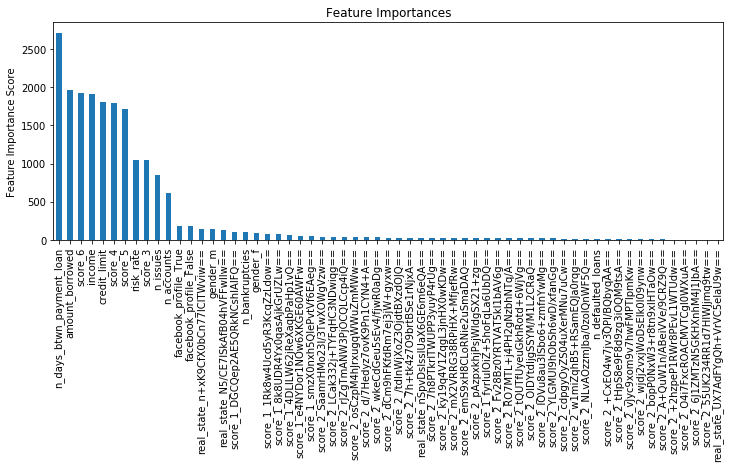

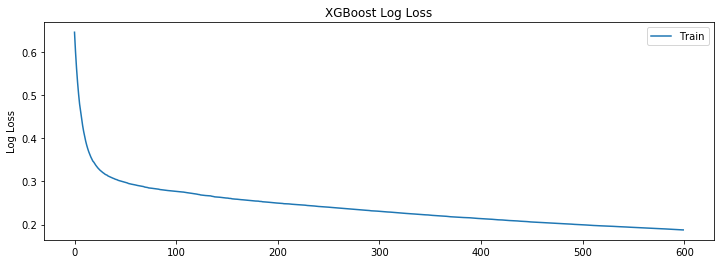

In [79]:
##########################################################################################
# XGBoosted Trees Model    
# using scikit-learn wrapper 
# Reference: http://xgboost.readthedocs.io/en/latest/python/python_intro.html
##########################################################################################

target = 'default'
IDcol = 'ids'

#Choose all columns except target & IDcol
predictors = [x for x in xtrain.columns if x not in [target, IDcol]]

### Setup Parameters
# We used a conservative approach for selecting the parameters.
# GridSearchCV can be used to optimize the parameters even more.
# Reference: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#####

bst = XGBClassifier(
 learning_rate =0.1,
 n_estimators=600,
 max_depth=6, 
 min_child_weight=4,
 gamma=0,
 subsample=0.8, #reducing overfitting
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 max_delta_step = 10, #Limiting delta step because of imbalanced data
 reg_alpha=0.01,
 reg_lambda=0.9,
 nthread=4,
 seed=27)

### XGBoost Trees Model Results

flag_CV = True #Cross-Validation flag, if set to True it will use CV (This step can take 5~10 min)

if flag_CV:
    print("Boosting Trees (with Cross-Validation). This may take a while (~10 min)\n")
    skfold = ms.StratifiedKFold(n_splits=5, random_state=42)
    accuracy = ms.cross_val_score(bst, xtrain[predictors], xtrain[target], cv=skfold, scoring="neg_log_loss")
    print("LogLoss Score: %.3f (%.2f%%)" % (-1.0*accuracy.mean(), accuracy.std()*100))

#Fitting
print("Fitting...")
bst.fit(xtrain[predictors],xtrain[target], early_stopping_rounds=20, eval_set=[(xtrain[predictors],xtrain[target])],eval_metric='logloss',verbose=False)

if flag_CV == False:
    pred_prob = bst.predict_proba(xtrain[predictors]) #probabilities
    y_pred = bst.predict(xtrain[predictors])
    ll_accuracy = log_loss(xtrain[target], pred_prob)
    validationScore = accuracy_score(xtrain[target], y_pred)
    print("LogLoss Score: %.3f" % ll_accuracy)             
    print("Accuracy: %.3f%%" % (100.0*validationScore)) 

    
#Feature Importance
print("\n Feature Importance:")
feat_imp = pd.Series(bst.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [84]:
## (RF-related cell)

#### Cleaning train dataset for RANDOM FOREST MODEL ####
#
# Random Forest DON'T accept matrices with missing values


print("Cleaning train dataset. This may take a while...")
ftrain = train_original.dropna(subset=['default']) # drop default = NA (no label)

## Train dataset
ftrain = ftrain.drop('channel', axis=1)  # channel has just 1 value (No added information)

ftrain = ftrain.drop('reason', axis=1)   # reason is too sparce(~20K unique Values)

ftrain = ftrain.drop('job_name', axis=1) # job_name has too many categories (~42K)

ftrain = ftrain.drop('ok_since', axis=1) # ok_since has too many NAs (~35K)

ftrain = ftrain.drop('sign', axis=1)     #sign doesn't seems relevant

ftrain = ftrain.drop('zip', axis=1)      #Too many cateogires (830)

ftrain = ftrain.drop('state', axis=1)    # Not sure if I would include 'state', don't know what exactly that means

# Fill nas
ftrain['gender'] = ftrain['gender'].fillna('untold')
ftrain['facebook_profile'] = ftrain['facebook_profile'].fillna('untold')

ftrain[['n_bankruptcies','n_issues','n_defaulted_loans']] = ftrain[['n_bankruptcies','n_issues','n_defaulted_loans']].fillna(pd.to_numeric(ftrain[['n_bankruptcies','n_issues','n_defaulted_loans']].median(), downcast='integer'))
ftrain['credit_limit'] = ftrain['credit_limit'].fillna(ftrain['credit_limit'].median())

#Convert last_payment and end_last_loan to number of days between last_payment and end_last_loan
# A negative number means the last payment was made after the end of the end of last loan

ftrain['last_payment'] = pd.to_datetime(ftrain['last_payment'], infer_datetime_format=True)
ftrain['end_last_loan'] = pd.to_datetime(ftrain['end_last_loan'], infer_datetime_format=True)

def days_from_last_payment(row):
    if pd.isnull(row).any():
        return 0
    else:
        delta = row['end_last_loan'] - row['last_payment']
        return (delta / np.timedelta64(1, 'D'))
    
ftrain['n_days_btwn_payment_loan'] = ftrain[['last_payment','end_last_loan']].apply(days_from_last_payment, axis=1)

ftrain = ftrain.drop(['last_payment', 'end_last_loan'], axis=1)

#Convert booleans to 1, 0
ftrain['default'] = ftrain['default'].astype(int)

# Create a set of dummys for variables: score_1, score_2, borrowed_in_months, gender, real_state, facebook_profile
ftrain_dummies = pd.get_dummies(ftrain[['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile']])
ftrain = pd.concat([ftrain, ftrain_dummies], axis=1)
ftrain = ftrain.drop(['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile'], axis=1)
print("Done! Now you can run the RF model.")

Cleaning train dataset. This may take a while...
Done! Now you can run the RF model.


Training a Random forest model. This may take a while...
Random Forest (with Cross-Validation). This may take a while (~10 min)

LogLoss Score: 0.345 (0.74%)
Fitting...

 Feature Importance:


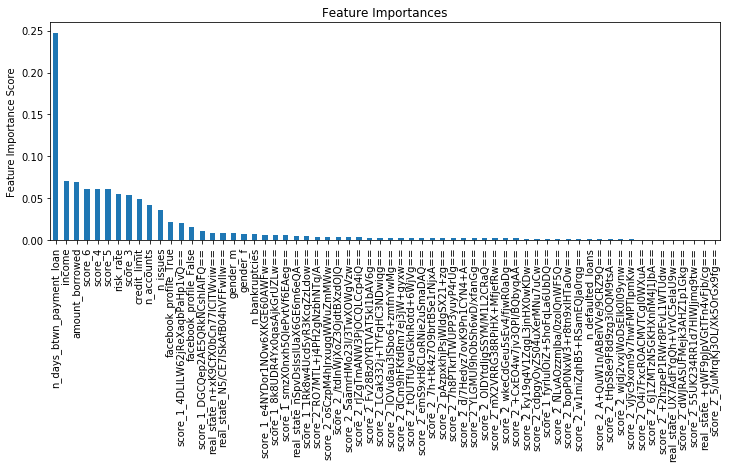

In [85]:
## (RF-related cell)

##########################################################################################
# Random Forest Model  
# A simpler to tune but still effective approach
# Reference: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##########################################################################################

target = 'default'
IDcol = 'ids'

#Choose all columns except target & IDcol
predictors = [x for x in xtrain.columns if x not in [target, IDcol]]

print('Training a Random forest model. This may take a while...')
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=150, class_weight='balanced_subsample', n_jobs=-1)

### Random Forest Model Results

flag_CV = True #Cross-Validation flag, if set to True it will use CV (This step can take 5~10 min)

if flag_CV:
    print("Random Forest (with Cross-Validation). This may take a while (~10 min)\n")
    skfold = ms.StratifiedKFold(n_splits=5, random_state=42)
    accuracy = ms.cross_val_score(forest, ftrain[predictors], ftrain[target], cv=skfold, scoring="neg_log_loss")
    print("LogLoss Score: %.3f (%.2f%%)" % (-1.0*accuracy.mean(), accuracy.std()*100))

#Fitting
print("Fitting...")
forest.fit(ftrain[predictors],ftrain[target])

if flag_CV == False:
    pred_prob = forest.predict_proba(ftrain[predictors]) #probabilities
    y_pred = forest.predict(ftrain[predictors])
    ll_accuracy = log_loss(ftrain[target], pred_prob)
    validationScore = accuracy_score(ftrain[target], y_pred)
    print("LogLoss Score: %.3f" % ll_accuracy)             
    print("Accuracy: %.3f%%" % (100.0*validationScore)) 

    
#Feature Importance
print("\n Feature Importance:")
feat_imp = pd.Series(forest.feature_importances_, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')          

In [86]:
###############
###  OUTPUT ###
###############

# Cleaning test dataset
print("Cleaning test dataset. This may take a while...")
xtest = test

## Test dataset
## Dropping same columns as in the Trainning process
xtest = xtest.drop('channel', axis=1)  
xtest = xtest.drop('reason', axis=1)   
xtest = xtest.drop('job_name', axis=1) 
xtest = xtest.drop('ok_since', axis=1) 
xtest = xtest.drop('sign', axis=1)     
xtest = xtest.drop('zip', axis=1)     
xtest = xtest.drop('state', axis=1)

#Convert last_payment and end_last_loan to number of days between last_payment and end_last_loan
# A negative number means the last payment was made after the end of the end of last loan
xtest['last_payment'] = pd.to_datetime(xtest['last_payment'], infer_datetime_format=True)
xtest['end_last_loan'] = pd.to_datetime(xtest['end_last_loan'], infer_datetime_format=True)

def days_from_last_payment(row):
    if pd.isnull(row).any():
        return np.nan
    else:
        delta = row['end_last_loan'] - row['last_payment']
        return (delta / np.timedelta64(1, 'D'))
    
xtest['n_days_btwn_payment_loan'] = xtest[['last_payment','end_last_loan']].apply(days_from_last_payment, axis=1)
xtest = xtest.drop(['last_payment', 'end_last_loan'], axis=1)

# Create a set of dummys for variables: score_1, score_2, borrowed_in_months, gender, real_state, facebook_profile
xtest_dummies = pd.get_dummies(xtest[['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile']])
xtest = pd.concat([xtest, xtest_dummies], axis=1)
xtest = xtest.drop(['score_1','score_2','borrowed_in_months','gender','real_state','facebook_profile'], axis=1)

print("Done! Now predicting probabilities using XGBoost Trees Model.")
print("This may take a while...")

#Prediction
IDcol = 'ids'
tpredictors = [x for x in xtest.columns if x not in [IDcol]]
predictions = bst.predict_proba(xtest[tpredictors],ntree_limit=bst.best_ntree_limit)
pred_prob = pd.DataFrame(predictions, columns=["prob0","predictions"])

output = pd.concat([xtest['ids'],pred_prob['predictions']], axis=1)
output.to_csv("predictions.csv", index=False)
print("Predictions Exported!")
output


Cleaning test dataset. This may take a while...
Done! Now predicting probabilities using XGBoost Trees Model.
This may take a while...
Predictions Exported!


,ids,predictions
0,e4366223-7aa2-0904-7a47-66479ae46b2a,0.103896
1,c6416108-c6d7-e6be-c4b5-923dd36c8ec4,0.089794
2,a90d3929-86ec-2414-89ba-543776b0e82b,0.013118
3,c5b96a7f-389a-28d0-242d-95db05e69da0,0.420434
4,1b461faa-926d-565d-b15d-0b452968ac81,0.308023
5,ca467139-2fe3-786b-b473-9bed607e71dc,0.004499
6,9d1cf9f2-0134-f173-b12a-df80ae8cfed0,0.086410
7,0895a45f-d761-8668-b7db-a1175f46af4c,0.010584
8,7dc64bfe-1d62-4a68-2287-3b272ad30208,0.005532
9,3d2705b3-d66b-b8f8-50d8-6327662334eb,0.049843
